In [1]:
import h5py
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense  
from keras import backend as K
from sklearn.model_selection import train_test_split
import pandas as pd
import tables
import matplotlib.pyplot as plt
import tensorflow as tf
import preprocessing


In [2]:
dataPath = '/home/WindowsDrive/Shared/Top_Tagging_Data/test.h5'
numJets = 1200000
maxConstits = 80

## Putting the data into an array, as well as making the arrays of labels and weights, then saving them to file so we don't need to leave them in memory the whole time

## DON'T RUN THIS AGAIN UNLESS YOU HAVE TO

In [3]:
with h5py.File(dataPath, 'r') as data:

    npDataLabels = np.array(data['labels'][:numJets])

    npDataWeights = np.array(data['weights'][:numJets])

    constitDataDict = {key: data[key][:numJets,...] for key in data.attrs.get('constit')}


In [4]:
processedConstitDict = preprocessing.constituent(constitDataDict, 80)
processedConstitDict = processedConstitDict.reshape(-1, maxConstits * processedConstitDict.shape[-1])
# del(constitDataDict)
# constitDf = pd.DataFrame(processedConstitDict)

/home/mkidson/gitRepos/Uni-Code/Honours/DS/Top_Tagging/preprocessing.py:90: RuntimeWarning: divide by zero encountered in log
  log_pt = np.log(pt)
/home/mkidson/gitRepos/Uni-Code/Honours/DS/Top_Tagging/preprocessing.py:91: RuntimeWarning: divide by zero encountered in log
  log_energy = np.log(energy)
/home/mkidson/gitRepos/Uni-Code/Honours/DS/Top_Tagging/preprocessing.py:98: RuntimeWarning: divide by zero encountered in log
  lognorm_pt = np.log(pt / sum_pt[:,np.newaxis])
/home/mkidson/gitRepos/Uni-Code/Honours/DS/Top_Tagging/preprocessing.py:99: RuntimeWarning: divide by zero encountered in log
  lognorm_energy = np.log(energy / sum_energy[:,np.newaxis])


In [5]:
del(constitDataDict)


data_train, data_test, labels_train, labels_test, weights_train, weights_test = train_test_split(processedConstitDict, npDataLabels, npDataWeights, test_size=0.33, random_state=69, shuffle=True)

## Here we import the data again and split it up into test and train

In [4]:
"""constitDataArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npConstitDataArr.npy')
labelsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataLabels.npy')
weightsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataWeights.npy')

pt_train, pt_test, eta_train, eta_test, phi_train, phi_test, E_train, E_test, labels_train, labels_test, weights_train, weights_test = train_test_split(constitDataArr[0], constitDataArr[1], constitDataArr[2], constitDataArr[3], labelsArr, weightsArr, test_size=0.33, random_state=69, shuffle=True)

del(constitDataArr)
del(labelsArr)
del(weightsArr)"""


"constitDataArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npConstitDataArr.npy')\nlabelsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataLabels.npy')\nweightsArr = np.load('/home/WindowsDrive/Shared/Top_Tagging_Data/npDataWeights.npy')\n\npt_train, pt_test, eta_train, eta_test, phi_train, phi_test, E_train, E_test, labels_train, labels_test, weights_train, weights_test = train_test_split(constitDataArr[0], constitDataArr[1], constitDataArr[2], constitDataArr[3], labelsArr, weightsArr, test_size=0.33, random_state=69, shuffle=True)\n\ndel(constitDataArr)\ndel(labelsArr)\ndel(weightsArr)"

## Trying high level now instead of constituent because fuck that much data

In [11]:
with h5py.File(dataPath, 'r') as data:

    npDataLabels = np.array(data['labels'])

    npDataWeights = np.array(data['weights'])
    
    hlDataArr = {key: data[key][...] for key in data.attrs.get('hl')}


## Preprocessing

In [12]:
processed_dict = preprocessing.high_level(hlDataArr)
processed_df = pd.DataFrame(hlDataArr)


In [13]:
data_train, data_test, labels_train, labels_test, weights_train, weights_test = train_test_split(processed_df, npDataLabels, npDataWeights, test_size=0.33, random_state=69, shuffle=True)

In [11]:
df_train = pd.DataFrame()
df_train["label"] = labels_train
df_train["weights"] = weights_train

sigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])
bkgSumWeights = np.sum(df_train[df_train["label"]==0]["weights"])

print(sigSumWeights)

scale = (bkgSumWeights/sigSumWeights)
df_train.loc[df_train.label==1, "weights"] *= scale

modsigSumWeights = np.sum(df_train[df_train["label"]==1]["weights"])

print(modsigSumWeights)


final_weights_train = df_train["weights"]

831597.0
833473.1


## Training now

In [6]:
model = Sequential()
model.add(keras.Input(shape=data_train.shape[1:]))
model.add(Dense(20, activation='relu', kernel_regularizer=None, kernel_initializer='glorot_uniform'))
model.add(Dense(20, activation='relu', kernel_regularizer=None, kernel_initializer='glorot_uniform'))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam')   

2022-09-18 13:54:11.585691: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 13:54:11.681983: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 13:54:11.683459: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-18 13:54:11.695108: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

In [7]:
model.fit(data_train, labels_train, sample_weight=weights_train, epochs=8, batch_size=100, verbose=1)

2022-09-18 13:54:30.749290: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1800960000 exceeds 10% of free system memory.
2022-09-18 13:57:15.735291: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1800960000 exceeds 10% of free system memory.


Epoch 1/8
8040/8040 [==============================] - 23s 3ms/step - loss: 0.5715
Epoch 2/8
8040/8040 [==============================] - 21s 3ms/step - loss: 0.5180
Epoch 3/8
8040/8040 [==============================] - 21s 3ms/step - loss: 0.4994
Epoch 4/8
8040/8040 [==============================] - 21s 3ms/step - loss: 0.4901
Epoch 5/8
8040/8040 [==============================] - 21s 3ms/step - loss: 0.4829
Epoch 6/8
8040/8040 [==============================] - 22s 3ms/step - loss: 0.4789
Epoch 7/8
8040/8040 [==============================] - 21s 3ms/step - loss: 0.4757
Epoch 8/8
8040/8040 [==============================] - 22s 3ms/step - loss: 0.4732


In [10]:
pred_test = model.predict(data_test)


12375/12375 [==============================] - 19s 2ms/step


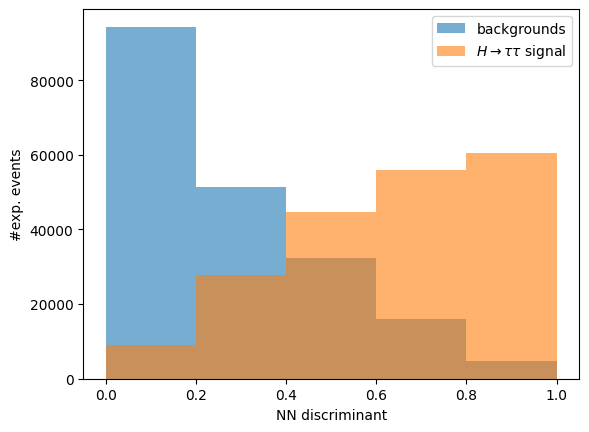

In [11]:
dfNN_test = pd.DataFrame()
dfNN_test["labels"] = labels_test
dfNN_test["predictions"] = pred_test
dfNN_test["weights"] = weights_test

signalVals = dfNN_test[dfNN_test['labels']== 1] 
backgroundVals = dfNN_test[dfNN_test['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

# bkgHistNN = plt.hist(backgroundVals['predictions'], bins=5, label="backgrounds", range=[0,1], alpha=0.6)
# sigHistNN = plt.hist(signalVals['predictions'], bins=5, label="signals", range=[0,1], alpha=0.6)

plt.legend()
# plt.yscale('log')
plt.show()

In [13]:
pred_train = model.predict(data_train)

25125/25125 [==============================] - 49s 2ms/step


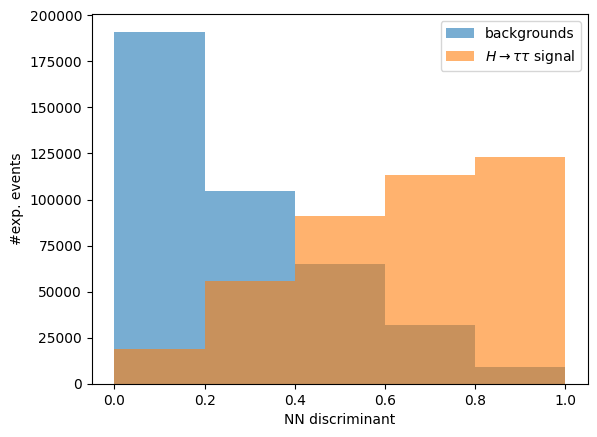

In [14]:
dfNN_train = pd.DataFrame()
dfNN_train["labels"] = labels_train
dfNN_train["predictions"] = pred_train
dfNN_train["weights"] = weights_train

signalVals = dfNN_train[dfNN_train['labels']== 1] 
backgroundVals = dfNN_train[dfNN_train['labels']== 0] 

plt.figure()
plt.xlabel("NN discriminant")
plt.ylabel("#exp. events")

bkgHistNN = plt.hist(backgroundVals["predictions"], bins=5, weights=backgroundVals["weights"],label="backgrounds", range=[0,1], alpha=0.6)
sigHistNN = plt.hist(signalVals["predictions"], bins=5, weights=signalVals["weights"],  label=r"$H\rightarrow \tau\tau$ signal",range=[0,1], alpha=0.6)

plt.legend()
#plt.yscale('log')
plt.show()

In [12]:
model.save('./models/constit_preprocessed_no_weights_processing_1200000_jets_80_max_constits')

INFO:tensorflow:Assets written to: ./models/constit_preprocessed_no_weights_processing_1200000_jets_80_max_constits/assets
